In [19]:
from matplotlib import pyplot as plt
import pandas as pd

from dlvc.datasets.cifar10 import  CIFAR10Dataset
from dlvc.datasets.dataset import Subset
from dlvc.models.vit import VisionTransformerShallow, VisionTransformerDeep, VisionTransformerDeepResidual
from dlvc.metrics import Accuracy
import torchvision.transforms.v2 as v2
from torch import optim
import torch 
from dlvc.trainer import ImgClassificationTrainer

In [2]:
train_transform = v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
                        ])

val_transform = v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
                        ])

# Define transformations for test set
test_transform = v2.Compose([
                        v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

In [3]:
train_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TRAINING, train_transform)
val_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py",Subset.VALIDATION, val_transform)
test_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TEST, test_transform)

In [4]:
def train_model(model):
    print("Training model: ", model.__class__.__name__)
    optimizer = optim.Adam(model.parameters())
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.09)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_metric = Accuracy(classes=train_data.classes)
    val_metric = Accuracy(classes=val_data.classes)
    device = torch.device("cpu")

    trainer_simple = ImgClassificationTrainer(
        model,
        optimizer,
        loss_fn,
        lr_scheduler,
        train_metric,
        val_metric,
        train_data,
        val_data,
        device,
        num_epochs = 10,
        training_save_dir="dlvc/weights/v2/" + model.__class__.__name__ + ".pt",
        batch_size=64,
        val_frequency=1
    )
    return trainer_simple

In [44]:
def test_model(model):

    print("Testing model: ", model.__class__.__name__)
    # Load test data
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
    # Load trained model
    model.load_state_dict(torch.load("dlvc/weights/v2/" + model.__class__.__name__ + ".pt"))
    model.eval()

    # Initialize metric for test set
    test_metric = Accuracy(classes=test_data.classes)

    # Define device
    device = torch.device("cpu")

    # Initialize metric for test set
    test_metric = Accuracy(classes=test_data.classes)

    # Evaluate model on test set
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            test_metric.update(output, labels)

    # Print test accuracy
    print("Test Accuracy:", test_metric.accuracy())
    print("Per-class Accuracy:", test_metric.per_class_accuracy())

    # Load existing results or create a new DataFrame
    try:
        results = pd.read_csv("results.csv")
    except FileNotFoundError:
        results = pd.DataFrame(columns=["model", "test_accuracy", "per_class_accuracy"])

    # Check if model is already in results
    if model.__class__.__name__ in results["model"].values:
        # Update results
        results.loc[results["model"] == model.__class__.__name__, "test_accuracy"] = test_metric.accuracy()
        results.loc[results["model"] == model.__class__.__name__, "per_class_accuracy"] = test_metric.per_class_accuracy()
    else:
        # Add model to results with concat
        results = pd.concat([results, pd.DataFrame([[model.__class__.__name__, test_metric.accuracy(), test_metric.per_class_accuracy()]], columns=["model", "test_accuracy", "per_class_accuracy"])], ignore_index=True)

    # Save results
    results.to_csv("results.csv", index=False)

    return model, test_metric

In [6]:
def plot_metrics(trainer):
    print("Plotting metrics for model: ", trainer.model.__class__.__name__)
    plt.style.use('ggplot')

    metrics = trainer.metrics_train
    metrics = list(zip(*metrics))
    loss = metrics[0]
    acc = metrics[1]
    class_acc = metrics[2]


    metrics_val = trainer.metrics_val
    metrics_val = list(zip(*metrics_val))
    loss_val = metrics_val[0]
    acc_val = metrics_val[1]
    class_acc_val = metrics_val[2]

    fig, ax = plt.subplots(1,3, figsize = (19,4))
    ax[0].plot(loss, label = "train")
    ax[0].plot(loss_val, label = "eval")
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(acc)
    ax[1].plot(acc_val)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[2].plot(class_acc)
    ax[2].plot(class_acc_val)
    ax[2].set_ylabel('Class Accuracy')
    ax[0].set_xlabel('Epoch')

    fig.legend()
    fig.suptitle("CNN training metrics")
    fig.savefig("img/v2/"+trainer.model.__class__.__name__ + ".png")

In [7]:
trainer_shallow = train_model(VisionTransformerShallow())

Training model:  VisionTransformerShallow


In [8]:
trainer_shallow.train()


TRAIN, EPOCH: 0 
Loss: 2.1543030738830566
Accuracy: 0.1995
Class Accuracy: 0.19884062483906745

VALIDATION, EPOCH: 0 
Loss: 2.1669392585754395
Accuracy: 0.2055
Class Accuracy: 0.2051470226608217
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 2.054473876953125
Accuracy: 0.2501
Class Accuracy: 0.24962077364325524

VALIDATION, EPOCH: 1 
Loss: 1.841219186782837
Accuracy: 0.2619
Class Accuracy: 0.2613637402653694
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 1.9279429912567139
Accuracy: 0.2671
Class Accuracy: 0.26674995943903923

VALIDATION, EPOCH: 2 
Loss: 1.7117326259613037
Accuracy: 0.2674
Class Accuracy: 0.2668632209300995
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 3 
Loss: 2.3672637939453125
Accuracy: 0.2672
Class Accuracy: 0.26710926443338395

VALIDATION, EPOCH: 3 
Loss: 1.7835352420806885
Accuracy: 0.265

Plotting metrics for model:  VisionTransformerShallow


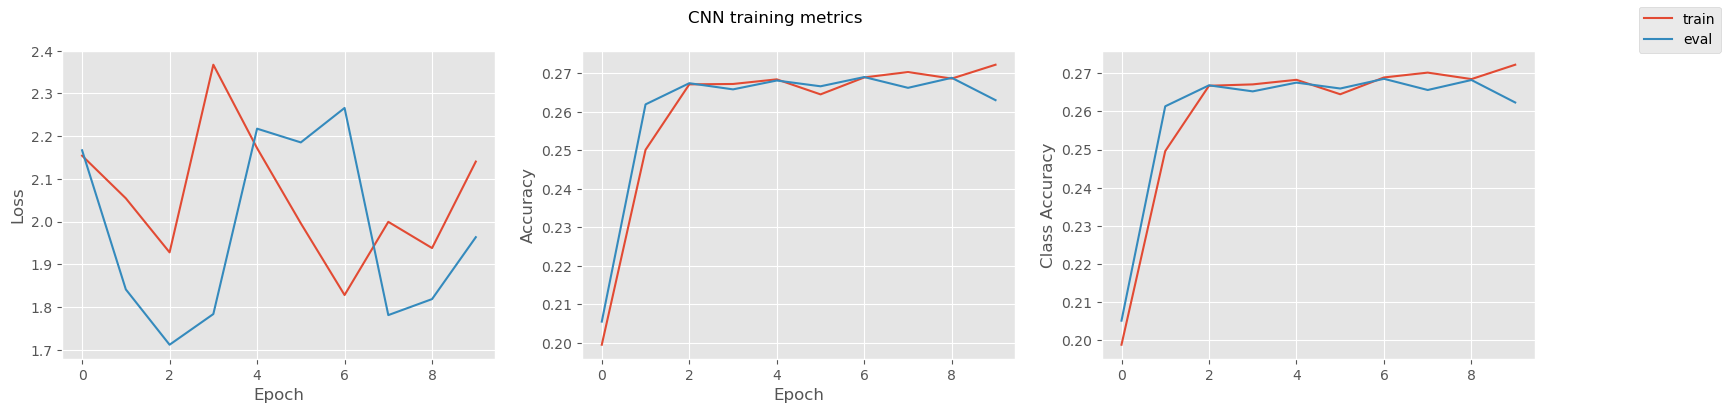

In [9]:
plot_metrics(trainer_shallow)

In [45]:
shallow_model, shallow_test_metric = test_model(VisionTransformerShallow())

Testing model:  VisionTransformerShallow
Test Accuracy: 0.2711
Per-class Accuracy: 0.2710999995470047


In [11]:
trainer_deep = train_model(VisionTransformerDeep())

Training model:  VisionTransformerDeep


In [12]:
trainer_deep.train()


TRAIN, EPOCH: 0 
Loss: 2.312384843826294
Accuracy: 0.0997
Class Accuracy: 0.09908083695918321

VALIDATION, EPOCH: 0 
Loss: 2.3006322383880615
Accuracy: 0.098
Class Accuracy: 0.1
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 2.290004253387451
Accuracy: 0.1001
Class Accuracy: 0.09726023972034455

VALIDATION, EPOCH: 1 
Loss: 2.3127670288085938
Accuracy: 0.098
Class Accuracy: 0.1
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 2.3027424812316895
Accuracy: 0.103
Class Accuracy: 0.1

VALIDATION, EPOCH: 2 
Loss: 2.286618232727051
Accuracy: 0.098
Class Accuracy: 0.1
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 3 
Loss: 2.3039445877075195
Accuracy: 0.103
Class Accuracy: 0.1

VALIDATION, EPOCH: 3 
Loss: 2.298196315765381
Accuracy: 0.098
Class Accuracy: 0.1
Best mean per class accuracy on validation data set is higher. 

Plotting metrics for model:  VisionTransformerDeep


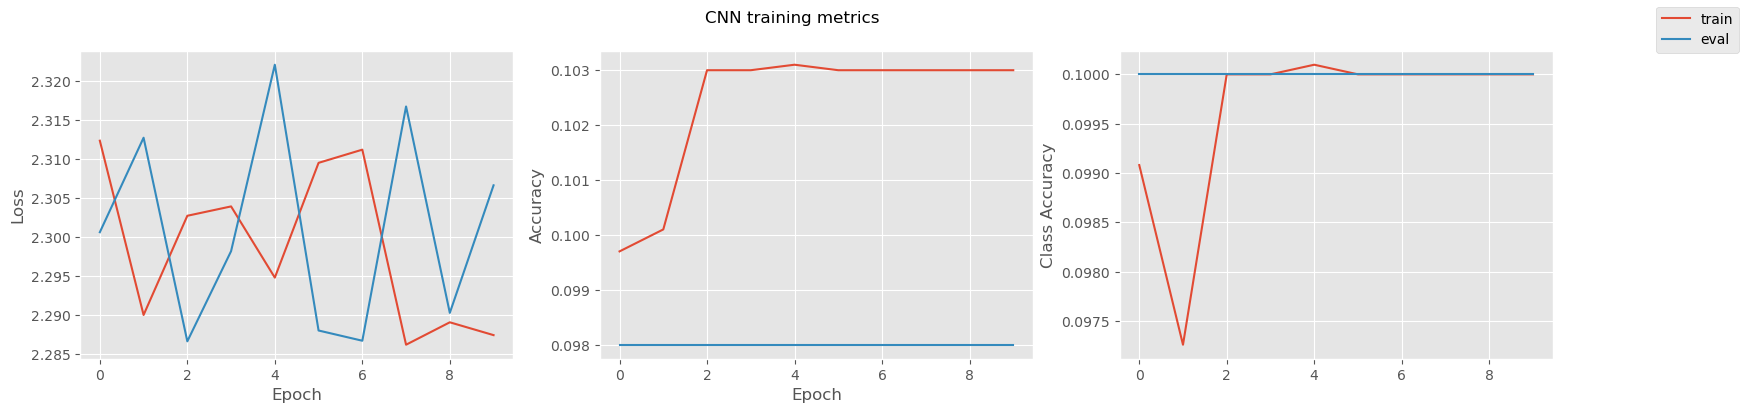

In [13]:
plot_metrics(trainer_deep)

In [46]:
deep_model, deep_test_metric = test_model(VisionTransformerDeep())

Testing model:  VisionTransformerDeep
Test Accuracy: 0.1
Per-class Accuracy: 0.1


In [15]:
trainer_deep_residual = train_model(VisionTransformerDeepResidual())

Training model:  VisionTransformerDeepResidual


In [16]:
trainer_deep_residual.train()


TRAIN, EPOCH: 0 
Loss: 282.677490234375
Accuracy: 0.2153
Class Accuracy: 0.2152329295873642

VALIDATION, EPOCH: 0 
Loss: 321.19244384765625
Accuracy: 0.1675
Class Accuracy: 0.1715344415977597
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 43.489532470703125
Accuracy: 0.359
Class Accuracy: 0.35887813568115234

VALIDATION, EPOCH: 1 
Loss: 91.65110778808594
Accuracy: 0.3307
Class Accuracy: 0.33108199685811995
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 65.51573181152344
Accuracy: 0.3843
Class Accuracy: 0.38399064242839814

VALIDATION, EPOCH: 2 
Loss: 66.7964859008789
Accuracy: 0.3403
Class Accuracy: 0.3399046763777733
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 3 
Loss: 74.0278091430664
Accuracy: 0.3845
Class Accuracy: 0.3843308687210083

VALIDATION, EPOCH: 3 
Loss: 54.027225494384766
Accuracy: 0.3422
Class 

Plotting metrics for model:  VisionTransformerDeepResidual


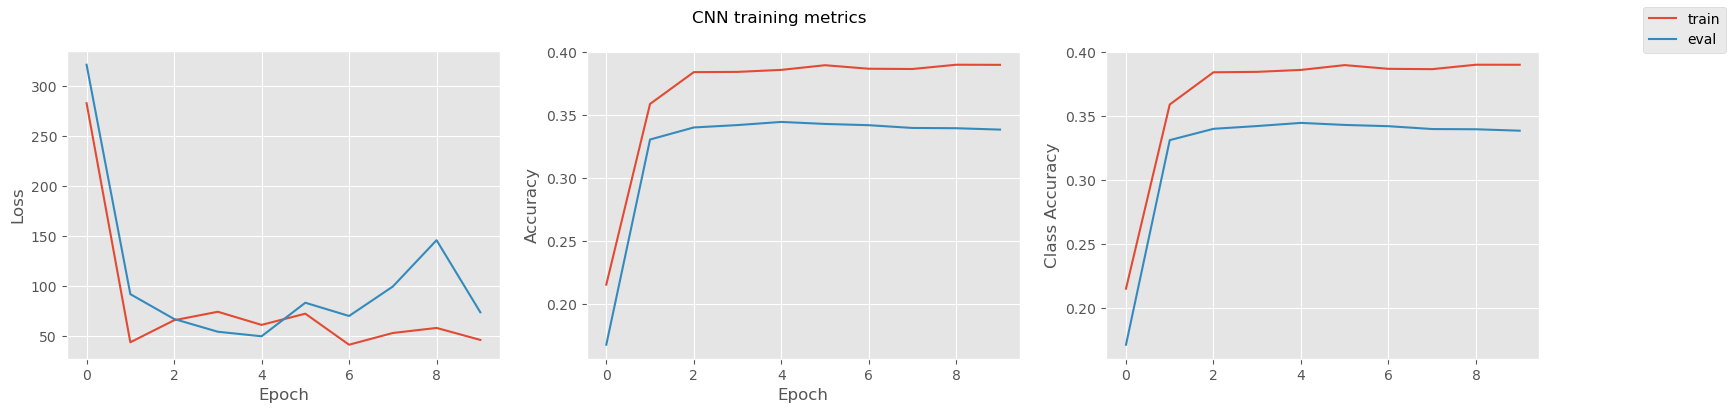

In [17]:
plot_metrics(trainer_deep_residual)

In [47]:
deep_residual_model, deep_residual_test_metric = test_model(VisionTransformerDeepResidual())

Testing model:  VisionTransformerDeepResidual


Test Accuracy: 0.3506
Per-class Accuracy: 0.35060000270605085
